In [6]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from operator import iadd
import seaborn as sns
import os
from collections import defaultdict
import math 
import scipy, scipy.signal
from collections import  OrderedDict

def plot_states_2D(dseries,name,first=False,eps = 1.0):
    """
    visualize 2D exploration through visited state space points during training
    last = visualize state space points for
          <1.0 percent of training
          >1.0 last number of episodes
    """
    states_arr = [OrderedDict((k, v) for  (k,v) in sorted(states.iteritems())) for states in dseries['states']]
    x_list = []
    dx_list = []
    val=16200
    max_ep = find_nearest(get_wallclock_time(dseries),val)
    for ep_batch in states_arr:
        for k,ep in ep_batch.iteritems():
            x =   [s[0] for s in ep]
            dx =   [s[1] for s in ep]
            x_list = x_list+x
            dx_list = dx_list +dx
            if k>=max_ep:
                break
    dx = np.array(dx_list)
    x = np.array(x_list)
    if np.abs(eps)<1.0: pp = int(len(x)*eps)
    else: pp = np.abs(eps)*20
    if eps<0:
        x = x[-pp:]
        dx = dx[-pp:]
    else:
        x = x[:pp]
        dx = dx[:pp]      
    print(len(x))
    b= sns.jointplot(x=x, y=dx, xlim=(-10,10),ylim=(-10,10),color = 'k',s=0.15)
    b.set_axis_labels('x', 'dx', fontsize=20)
    b.ax_joint.set_xticks([-10, -3, 3, 10])
    b.ax_joint.set_yticks([-10, -3, 3, 10])
    yticks = b.ax_joint.get_yticks()
    xticks = b.ax_joint.get_xticks()
    b.ax_joint.set_xticklabels(xticks,fontsize=16)
    if first:
        b.ax_joint.set_yticklabels(yticks,fontsize=16)
        b.ax_joint.set_yticklabels([-10, -3, 3, 10])
    else:
        b.ax_joint.set_yticklabels([])
    phantom, = b.ax_joint.plot([], [], linestyle="", alpha=0)
    annot_kws = {'prop':{ 'size':18}}
    nep = len(dseries['rewards_sum'])
    b.ax_joint.legend([phantom],['nmcts='+str(name)+ ', #eps.={:.0f}'.format(nep)],loc=4,**annot_kws)

    return b

class SeabornFig2Grid():
    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())
        


In [2]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def batch(iterable,n=1):
    l = len(iterable)
    for ndx in range(0,l,n):
        yield iterable[ndx:min(ndx+n,l)]

def smooth(y, box_pts,mode):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode=mode)
    return y_smooth

def get_wallclock_time(sdata,w=50):
    # get wallclock time from pickled results
    wallclock_time=[]
    start = 0
    for x,y in zip(batch(sdata['wallclock'],w),batch(sdata['wallclock_nn'],w)):
        wDur_nn = y
        wTime_nn = reduce(lambda result, x: iadd(result, [result[-1] + x]),wDur_nn, [0])
        wDur_mcts = x
        varx = list(np.array(wTime_nn[:-1])+np.array(wDur_mcts)) 
        varx = [x+start for x in varx]
        wallclock_time += varx
        start = varx[-1]
    return wallclock_time                   

def get_results_dict(_dir,_type,_last=False):
    # gather results paths in dictionary
    results = defaultdict(dict)
    df = pd.DataFrame(results, columns=['path'])
    for root, dirs, files in os.walk(_dir):
        for file in files:
            if file.endswith(str(_type) + ".pkl"):
                run = os.path.basename(os.path.normpath(root))
                _file =  '_'.join(file.rsplit('_')[:-2])
                if _file != run:
                    _file = '_'.join(file.rsplit('_')[:-1])
                    if _last: _id = 'all'
                    else: _id = 'last'
                    results[_file][_id] = os.path.join(root,file)
                else:
                    _id = (int(file.rsplit('_')[-2:][0]))
                    results[_file][_id] = os.path.join(root,file)
    return results

def get_all_results(_dir,_type):
    # read pickled results
    results = get_results_dict(_dir,_type)
    all_results = {}
    for key in results.keys():
        results_sub = OrderedDict((k, v) for  (k,v) in sorted(results[key].iteritems()))
        if _type=='main':
            data = {}
            for k,v in results_sub.iteritems():
                try:data[k]=  load_main_data(v,_type)
                except ValueError: print("not read: " + str(v))
            data_keys = data[sorted(data.keys())[0]].keys()
            sdata = {key:get_dataseries(data,key) for key in data_keys}
            sdata['wallclock_time'] = get_wallclock_time(sdata)
            all_results[key] = sdata
    return results, all_results

def get_dataseries(d,key):
    _=[d[k][key] for k,v in sorted(d.iteritems())]
    if key == 'states':
        return [OrderedDict((k, v) for  (k,v) in sorted(states.iteritems())) for states in _]
    else:
        return [item for sublist in _ for item in sublist]
    
def load_main_data(path,t):
    # load pickled results
    v= {}
    data = pd.read_pickle(path)
    for key in ['steps_count','rewards_sum','loss_d1','wallclock',
                    'wallclock_nn','actions','niterations','grads_norm_clipped_d1']:
        v[key] = [data[ep].get(key,None) for ep in data.keys()]
    v['wallclock_time'] = reduce(lambda result, x: iadd(result, [result[-1] + x]),v['wallclock_nn'], [0])
    v['states'] = {ep: data[ep].get('states',None) for ep in data.keys()}
    return v

def get_smooth_df(dfs,window,subsample, _std=True, rescale=False):
    # smooth runs from different seeds (dfs dataframe list) with given window and subsampling
    try:
        df_wallclock = merge_dfs(dfs[0],dfs[1],'wallclock')
        try:
            df_wallclock= merge_dfs(df_wallclock,dfs[2],'wallclock')
        except:
            IndexError
    except IndexError:
        df_wallclock = dfs
        df_wallclock.columns = ['merged']
    N = window/2
    std = None
    df_wallclock = df_wallclock.iloc[::subsample, :]
    if _std:
        arr = df_wallclock['merged'].values
        arr = np.pad(df_wallclock.iloc[:, 0], (window//2, window-window//4), mode='edge')
        arr2 = arr**2
        ones = np.ones(arr.shape)
        kernel = np.ones((2*N+1))
        s = scipy.signal.convolve(arr, kernel, mode="valid")
        s2 = scipy.signal.convolve(arr2, kernel, mode="valid")
        ns = scipy.signal.convolve(ones, kernel, mode="valid")
        std = np.sqrt((s2 - s**2 / ns) / ns)/np.sqrt(3)
        std =std[::subsample]
    mode = 'valid'
    y = np.pad(df_wallclock.iloc[:,0], (window//2, window-window//4), mode='edge')
    y= smooth(y,window, mode) 
    x = df_wallclock.index
    x = np.pad(x, (window//2, window-window//4), mode='edge')
    x = (smooth(x, window, mode) )
    if len(std)!=len(y):std=np.pad(std, (0, len(y)-len(std)), 'constant')
    df = pd.DataFrame(y, index = x)
    df = df.dropna()
    if len(df)<len(std):std = std[:len(df)]
    return df,std

def merge_dfs(a,b,logdata):
    # merge together a,b dataframes based on time index
    a, b = a.copy(), b.copy()
    a.columns, b.columns = ['a'], ['b']
    m = a.merge(b, how='outer', left_index=True, right_index=True)
    m['idx'] = range(0,len(m))
    m[logdata] = m.index.tolist()
    m['merged']= [m.iloc[idx]['a'] if not math.isnan(m.iloc[idx]['a']) else m.iloc[idx]['b'] for idx in m['idx']]
    return pd.DataFrame(m['merged'], index =  m[logdata],columns = ['merged'])

## Results

In [7]:
results_path = ''
results = defaultdict(dict)
for nmcts in [16,32,64,128,'adaptive']:
    for i in  range(1,4):        
        name = os.path.join(results_path,'results_racecar_nmcts_'+str(nmcts)+'_'+str(i)+'.pickle')
        try: 
            with open(name, 'rb') as handle:
                results[nmcts][i] = pickle.load(handle)
        except: IOError
smoothed_results = {}
for nmcts in [16,32,64,128,'adaptive']:
    nmcts_d = results[nmcts]
    m = {k:pd.DataFrame(l['rewards_sum'], index=get_wallclock_time(l)) for k,l in nmcts_d.iteritems()}
    df = get_smooth_df(m.values(),200,1,)
    smoothed_results[nmcts] = df

1000


/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


1000
1000


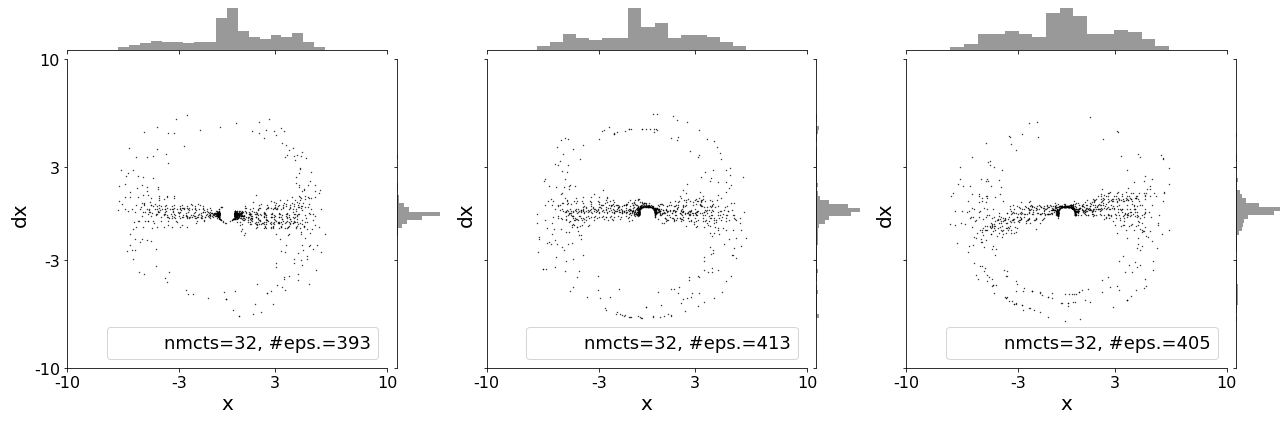

In [8]:
nmcts = 32
d = results[nmcts]
g0 = plot_states_2D(d[1],nmcts,True,-50)
g1 = plot_states_2D(d[2],nmcts,False,-50)
g2 = plot_states_2D(d[3],nmcts,False,-50)

fig = plt.figure(figsize=(18,6))
gs = gridspec.GridSpec(1,3)


mg0 = SeabornFig2Grid(g0, fig, gs[0])
mg1 = SeabornFig2Grid(g1, fig, gs[1])
mg2 = SeabornFig2Grid(g2, fig, gs[2])

gs.tight_layout(fig)
plt.show()

2000
2000
2000
2000
2000


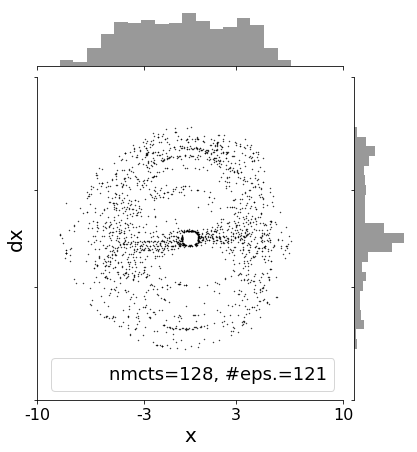

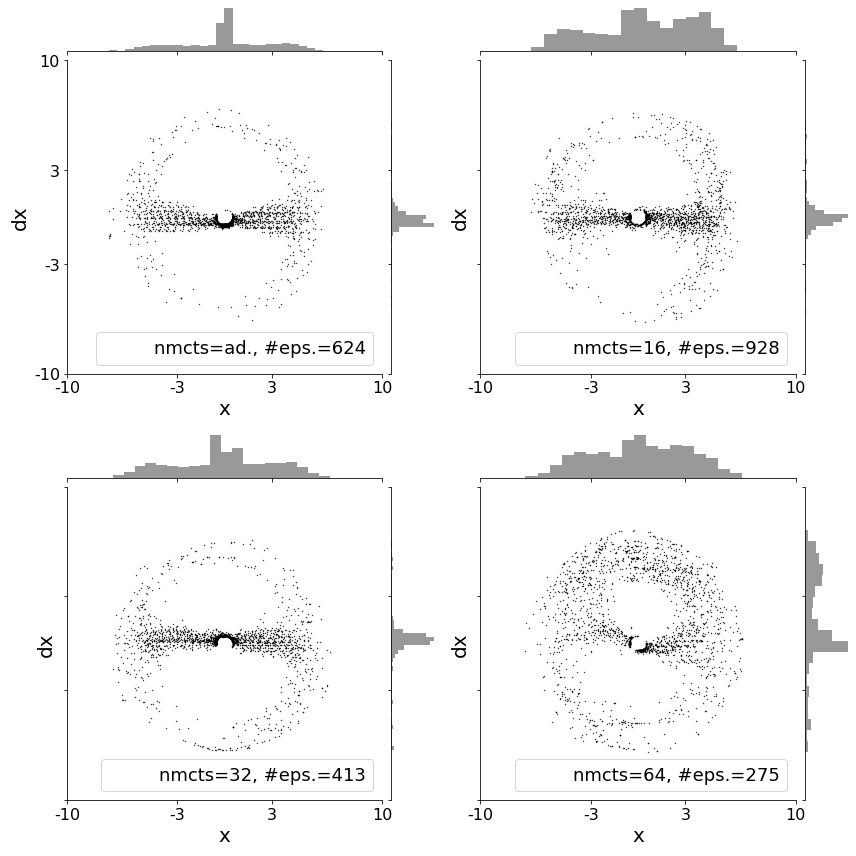

In [9]:
d = results['adaptive']
g0 = plot_states_2D(results['adaptive'][2],'ad.',True,-100)
g1 = plot_states_2D(results[16][2],'16',False,-100)
g2 = plot_states_2D(results[32][2],'32',False,-100)
g3 = plot_states_2D(results[64][2],'64',False,-100)
g4 = plot_states_2D(results[128][2],'128',False,-100)
fig = plt.figure(figsize=(12,12))

gs = gridspec.GridSpec(2,2)

mg0 = SeabornFig2Grid(g0, fig, gs[0])
mg1 = SeabornFig2Grid(g1, fig, gs[1])
mg2 = SeabornFig2Grid(g2, fig, gs[2])
mg3 = SeabornFig2Grid(g3, fig, gs[3])
# mg4 = SeabornFig2Grid(g4, fig, gs[4])

gs.tight_layout(fig)
fig.savefig('exampl.png')
plt.show()

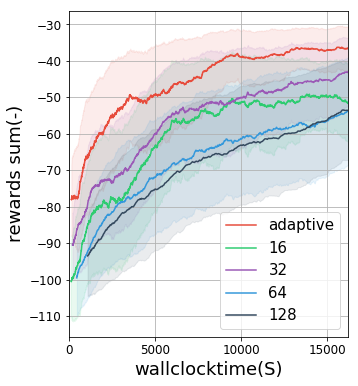

In [20]:
fig,ax = plt.subplots(figsize=(5,6))
colors =  ["#e74c3c", "#2ecc71","#9b59b6", "#3498db", "#34495e"]
for nmcts,c in zip(['adaptive',16,32,64,128],colors):
    df = smoothed_results[nmcts]
    ax.plot(df[0],label = nmcts,color=c)
    ax.fill_between(df[0].index,
                         df[0].values.flatten() - df[1],
                         df[0].values.flatten() + df[1],
                         alpha = 0.1,color = c) 
annot_kws = {'prop':{ 'size':15}}
plt.legend(loc=4, **annot_kws)
plt.xlim(0,16200)
plt.grid()
plt.ylabel('rewards sum(-)',fontsize=18)
plt.xlabel('wallclocktime(S)',fontsize=18)
plt.xticks([0,5000,10000,15000],fontsize=12)
plt.yticks(fontsize=12)

fig.savefig('rewards_rc.png')
plt.show()